# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## - Read references

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

In [8]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

In [9]:
## Create Category for transcripts and store values

ref_transcripts = ref_transcripts.loc[ref_transcripts["transcript_id"].str.startswith("BambuTx")].copy()

ref_transcripts.loc[ref_transcripts["gene_id"].str.startswith("BambuGene"), "Type"] = "NFN"
ref_transcripts.loc[~(ref_transcripts["gene_id"].str.startswith("BambuGene")), "Type"] = "NFK"
ref_transcripts.loc[ref_transcripts["chr"] == "MT", "Type"] = "NFM"


all_nfn = ref_transcripts.loc[ref_transcripts["Type"] == "NFN"].shape[0]
all_nfk = ref_transcripts.loc[ref_transcripts["Type"] == "NFK"].shape[0]
all_nfm = ref_transcripts.loc[ref_transcripts["Type"] == "NFM"].shape[0]

In [10]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/raw/1st_rebuttal_data/GTEX_with_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

In [11]:
## Create Category for transcripts and store values

ref_transcripts = ref_transcripts.loc[ref_transcripts["transcript_id"].str.startswith("BambuTx")].copy()

ref_transcripts.loc[ref_transcripts["gene_id"].str.startswith("BambuGene"), "Type"] = "NFN"
ref_transcripts.loc[~(ref_transcripts["gene_id"].str.startswith("BambuGene")), "Type"] = "NFK"
ref_transcripts.loc[ref_transcripts["chr"] == "MT", "Type"] = "NFM"


gtex_all = ref_transcripts.shape[0]
gtex_nfn = ref_transcripts.loc[ref_transcripts["Type"] == "NFN"].shape[0]
gtex_nfk = ref_transcripts.loc[ref_transcripts["Type"] == "NFK"].shape[0]
gtex_nfm = ref_transcripts.loc[ref_transcripts["Type"] == "NFM"].shape[0]

## - Open tracking data

In [12]:
## Download data
ours_hf_vs_gtex_all_107 = pd.read_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu/tracking_files/OURS_HF_vs_GTEx_ENSEMBL_107_ALL.tracking", sep="\t", header=None, usecols=[2,3,4],
                         names=["gtex_107_all_name", "category", "our_name"])

ours_all_vs_gtex_all_107 = pd.read_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu/tracking_files/OURS_ALL_vs_GTEx_ENSEMBL_107_ALL.tracking", sep="\t", header=None, usecols=[2,3,4],
                         names=["gtex_107_all_name", "category", "our_name"])

In [13]:
## Number of new transcripts, high-confidence & no filter (all)
hf_number = ours_hf_vs_gtex_all_107.shape[0]

all_number = ours_all_vs_gtex_all_107.shape[0]

In [14]:
## Only keep "=" transcripts
ours_hf_vs_gtex_all_107 = ours_hf_vs_gtex_all_107.loc[ours_hf_vs_gtex_all_107["category"] == "="].copy()
ours_all_vs_gtex_all_107 = ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["category"] == "="].copy()

In [15]:
## Create boolean
ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["category"] == "=", "ours_all_vs_gtex_107_all"] = True
ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["category"] != "=", "ours_all_vs_gtex_107_all"] = False

In [16]:
## Create gene_id and transcript_id
ours_hf_vs_gtex_all_107["gene_id"] = ours_hf_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[0]
ours_hf_vs_gtex_all_107["transcript_id"] = ours_hf_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[1]

ours_all_vs_gtex_all_107["gene_id"] = ours_all_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[0]
ours_all_vs_gtex_all_107["transcript_id"] = ours_all_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[1]

In [17]:
## Add gene_name and chromosomes
ours_hf_vs_gtex_all_107 = ours_hf_vs_gtex_all_107.merge(orig_ref[["gene_id", "gene_name", "chr"]], on="gene_id", how="left")
ours_all_vs_gtex_all_107 = ours_all_vs_gtex_all_107.merge(orig_ref[["gene_id", "gene_name", "chr"]], on="gene_id", how="left")

In [18]:
## Create sub-category separations
df_new_from_new_hf_all = ours_hf_vs_gtex_all_107.loc[ours_hf_vs_gtex_all_107["gene_id"].str.contains("BambuGene")].copy()
df_new_from_known_hf_all = ours_hf_vs_gtex_all_107.loc[~ours_hf_vs_gtex_all_107["gene_id"].str.contains("BambuGene")].copy() 
df_new_from_known_nuclear_hf_all = df_new_from_known_hf_all.loc[df_new_from_known_hf_all["chr"] != "MT"].copy()
df_new_from_known_mito_all_all = ours_hf_vs_gtex_all_107.loc[ours_hf_vs_gtex_all_107["chr"] == "MT"].copy()

In [19]:
## Create sub-category separations
df_new_from_new_all_all = ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["gene_id"].str.contains("BambuGene")].copy()
df_new_from_known_all_all = ours_all_vs_gtex_all_107.loc[~ours_all_vs_gtex_all_107["gene_id"].str.contains("BambuGene")].copy() 
df_new_from_known_nuclear_all_all = df_new_from_known_all_all.loc[df_new_from_known_all_all["chr"] != "MT"].copy()
df_new_from_known_mito_all_all = df_new_from_known_all_all.loc[df_new_from_known_all_all["chr"] == "MT"].copy()

## - Display results

In [20]:
print("Number of HF transcripts:", hf_number)
print("Number of HF transcripts NFK:", "428")
print("Number of HF transcripts NFN:", "267")
print("Number of HF transcripts NFM:", "5")

print()

print("Number of validated HF transcripts:", ours_hf_vs_gtex_all_107.shape[0])
print("Number of validated HF transcripts NFK:", df_new_from_known_nuclear_hf_all.shape[0])
print("Number of validated HF transcripts NFN:", df_new_from_new_hf_all.shape[0])
print("Number of validated HF transcripts NFM:", df_new_from_known_mito_all_all.shape[0])

Number of HF transcripts: 700
Number of HF transcripts NFK: 428
Number of HF transcripts NFN: 267
Number of HF transcripts NFM: 5

Number of validated HF transcripts: 289
Number of validated HF transcripts NFK: 239
Number of validated HF transcripts NFN: 50
Number of validated HF transcripts NFM: 0


In [21]:
print("Number of ALL transcripts:", all_number)
print("Number of ALL transcripts NFK:", str(all_nfk))
print("Number of ALL transcripts NFN:", str(all_nfn))
print("Number of ALL transcripts NFM:", str(all_nfm))

print()

print("Number of validated ALL transcripts:", ours_all_vs_gtex_all_107.shape[0])
print("Number of validated ALL transcripts NFK:", df_new_from_known_nuclear_all_all.shape[0])
print("Number of validated ALL transcripts NFN:", df_new_from_new_all_all.shape[0])
print("Number of validated ALL transcripts NFM:", df_new_from_known_mito_all_all.shape[0])

Number of ALL transcripts: 3429
Number of ALL transcripts NFK: 1534
Number of ALL transcripts NFN: 1860
Number of ALL transcripts NFM: 34

Number of validated ALL transcripts: 932
Number of validated ALL transcripts NFK: 615
Number of validated ALL transcripts NFN: 317
Number of validated ALL transcripts NFM: 0


In [22]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)

# figure size in millimiters
rcParams['figure.figsize'] = (85*mm, 90*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

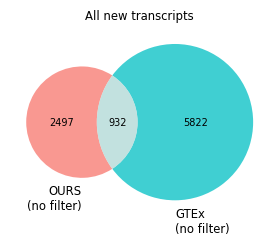

In [23]:
venn2(subsets=((3429 - 932), (gtex_all - 932), 932),
      set_labels=('OURS\n(no filter)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("All new transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_ALL_new_vs_GTEX_all_new.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

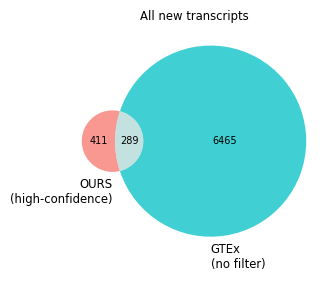

In [24]:
venn2(subsets=((700 - 289), (gtex_all - 289), 289),
      set_labels=('OURS\n(high-confidence)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("All new transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_HF_new_vs_GTEX_all_new.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

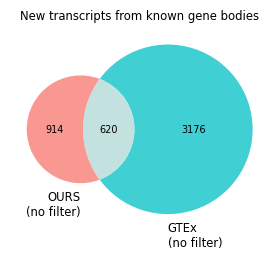

In [25]:
venn2(subsets=((1534 - 620), (gtex_nfk - 620), 620),
      set_labels=('OURS\n(no filter)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New transcripts from known gene bodies")


plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_ALL_nfk_vs_GTEX_all_nfk.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

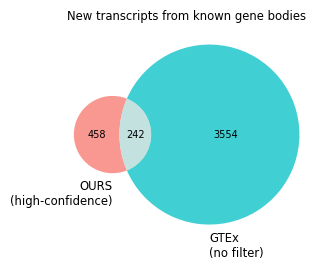

In [26]:
venn2(subsets=((700 - 242), (gtex_nfk - 242), 242),
      set_labels=('OURS\n(high-confidence)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New transcripts from known gene bodies")


plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_HF_nfk_vs_GTEX_all_nfk.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

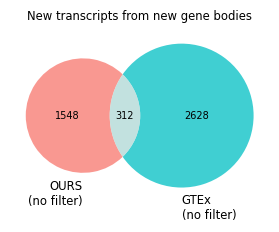

In [27]:
venn2(subsets=((1860 - 312), (gtex_nfn - 312), 312),
      set_labels=('OURS\n(no filter)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New transcripts from new gene bodies")


plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_ALL_nfn_vs_GTEX_all_nfn.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

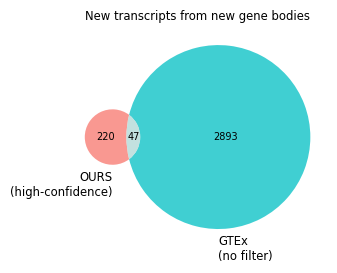

In [28]:
venn2(subsets=((267 - 47), (gtex_nfn - 47), 47),
      set_labels=('OURS\n(high-confidence)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New transcripts from new gene bodies")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_HF_nfn_vs_GTEX_all_nfn.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

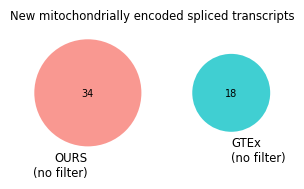

In [29]:
venn2(subsets=((34 - 0), (gtex_nfm - 0), 0),
      set_labels=('OURS\n(no filter)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New mitochondrially encoded spliced transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_ALL_nfm_vs_GTEX_all_nfm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

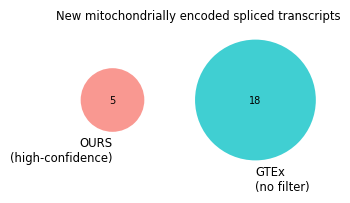

In [30]:
venn2(subsets=((5 - 0), (gtex_nfm - 0), 0),
      set_labels=('OURS\n(high-confidence)', 'GTEx\n(no filter)'),
     set_colors=(ggplot2_colors[0], ggplot2_colors[4]), alpha=0.75)

plt.title("New mitochondrially encoded spliced transcripts")

plt.savefig('../../../figures/1st_rebuttal_figures/discovery_comparison_bambu/venn_OURS_HF_nfm_vs_GTEX_all_nfm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make output table

In [38]:
## Download data
ours_hf_vs_gtex_all_107 = pd.read_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu/tracking_files/OURS_HF_vs_GTEx_ENSEMBL_107_ALL.tracking", sep="\t", header=None, usecols=[2,3,4],
                         names=["gtex_107_all_name", "category", "our_name"])

ours_all_vs_gtex_all_107 = pd.read_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu/tracking_files/OURS_ALL_vs_GTEx_ENSEMBL_107_ALL.tracking", sep="\t", header=None, usecols=[2,3,4],
                         names=["gtex_107_all_name", "category", "our_name"])

In [39]:
## Was same transcript idenpendently discovered with ENSEMBL 107 using Bambu on GTEx data
ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["category"] == "=", "is_independently_discovered_in_GTEx_using_Bambu_with_ENSEMBL_107"] = True
ours_all_vs_gtex_all_107.loc[~(ours_all_vs_gtex_all_107["category"] == "="), "is_independently_discovered_in_GTEx_using_Bambu_with_ENSEMBL_107"] = False

In [40]:
## Create gene_id and transcript_id
ours_hf_vs_gtex_all_107["gene_id"] = ours_hf_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[0]
ours_hf_vs_gtex_all_107["transcript_id"] = ours_hf_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[1]

ours_all_vs_gtex_all_107["gene_id"] = ours_all_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[0]
ours_all_vs_gtex_all_107["transcript_id"] = ours_all_vs_gtex_all_107["our_name"].str.split(":", expand=True)[1].str.split("|", expand=True)[1]

In [41]:

ours_all_vs_gtex_all_107.loc[ours_all_vs_gtex_all_107["transcript_id"].isin(ours_hf_vs_gtex_all_107["transcript_id"]), "is_high-confidence"] = True
ours_all_vs_gtex_all_107.loc[~(ours_all_vs_gtex_all_107["transcript_id"].isin(ours_hf_vs_gtex_all_107["transcript_id"])), "is_high-confidence"] = False

In [42]:
ours_all_vs_gtex_all_107 = ours_all_vs_gtex_all_107.merge(orig_ref[["gene_id", "gene_name", "chr"]], on="gene_id", how="left")
ours_all_vs_gtex_all_107['gene_name'].fillna(ours_all_vs_gtex_all_107['gene_id'], inplace=True)

In [43]:
ours_all_vs_gtex_all_107 = ours_all_vs_gtex_all_107[['chr', 'gene_id', 'gene_name', 'transcript_id', 
                                                     'is_independently_discovered_in_GTEx_using_Bambu_with_ENSEMBL_107',
                                                     'is_high-confidence']].copy()

In [44]:
ours_all_vs_gtex_all_107.to_csv("../../../data/processed/1st_rebuttal/discovery_comparison_bambu/independent_discovery_validation_table.tsv",
                               sep="\t", index=False)